from: https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [8]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import modin.pandas as pd
import statsmodels.api as sm

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

In [11]:
df = pd.read_excel('data/superstore.xls')

In [12]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [15]:
print(df['Order Date'].min())
print(df['Order Date'].max())

2014-01-03 00:00:00
2017-12-30 00:00:00


In [18]:
furniture = df.loc[df.Category == 'Furniture']

In [19]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

### Data Pre Processing

In [20]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [21]:
cols = ['Row ID'
        , 'Order ID'
        , 'Ship Date'
        , 'Ship Mode'
        , 'Customer ID'
        , 'Customer Name'
        , 'Segment'
        , 'Country'
        , 'City'
        , 'State'
        , 'Postal Code'
        , 'Region'
        , 'Product ID'
        , 'Category'
        , 'Sub-Category'
        , 'Product Name'
        , 'Quantity'
        , 'Discount'
        , 'Profit']
furniture.drop(cols
               , axis = 1
               , inplace = True
              )

In [22]:
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [23]:
furniture.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


In [24]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture.head()

,Order Date,0
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


### Set Time Series Data as Index

In [25]:
furniture = furniture.set_index('Order Date')
furniture.head()

,0
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


In [33]:
furniture.rename(columns={0: "Total Sales"}, inplace=True)

In [35]:
y = furniture['Total Sales'].resample('MS').mean()

In [36]:
y['2017']

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Total Sales, dtype: float64

### Visualize Data:

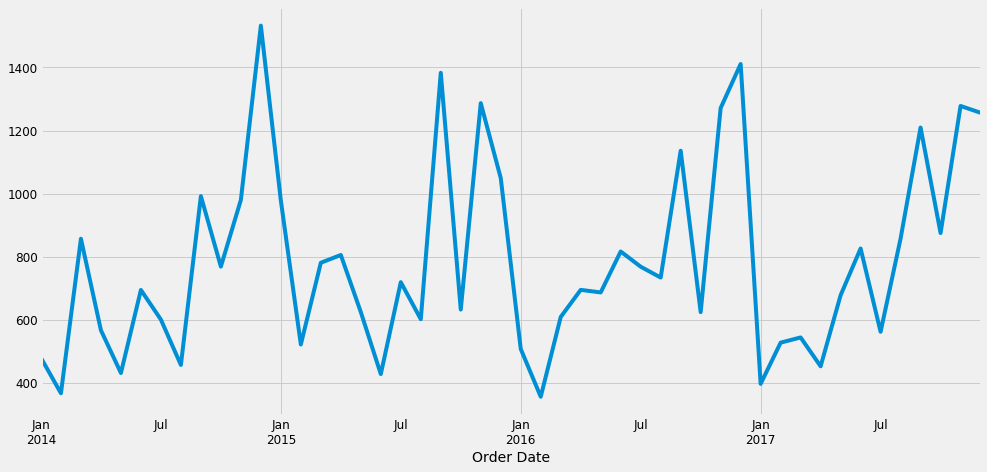

In [38]:
y.plot(figsize=(15,7));

In [42]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

#### There are obvious seasonal patterns

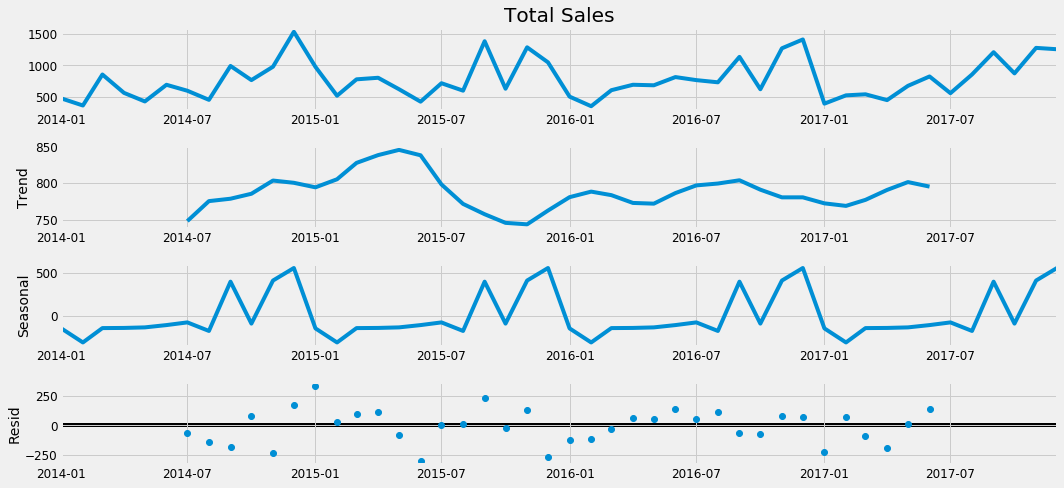

In [44]:
decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomposition.plot();

### Time series forcasting with ARIMA
<br>
ARIMA stands for Autoregressive Integrated Moving Average

In [51]:
import itertools

In [52]:
p = d = q= range(0, 2)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [53]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of Parameter Combinations for Seasonal ARIMA...')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[1]}')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[2]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[3]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[4]}')

Examples of Parameter Combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [55]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y
                                            , order=param
                                            , seasonal_order=param_seasonal
                                            , enforce_stationarity=False
                                            , enforce_invertibility=False
                                           )
            results = mod.fit()
            print(f'ARIMA{param}x{param_seasonal}12 - AIC:{results.aic}')
        except: 
            continue
        

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1526.6646435881128
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.71701309202774
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899793829
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1402.3936867800505
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.24882803029294
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.92522707581
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2900.5279890044303
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809134
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.62613896732927
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5730681144165
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468657
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576431208
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1420.8968510776567
ARIMA(0, 1, 0)x(0, 

#### The last number is the best

In [59]:
results.aic

283.36610144094936

In [60]:
mod = sm.tsa.statespace.SARIMAX(y
                                , order = (1, 1, 1)
                                , seasonal_order=(1, 1, 1, 12)
                                , enforce_stationarity=False
                                , enforce_invertibility=False
                               )
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0949      0.313     -0.303      0.762      -0.708       0.518
ma.L1         -1.0000      0.415     -2.409      0.016      -1.814      -0.186
ar.S.L12      -0.0036      0.424     -0.008      0.993      -0.834       0.827
ma.S.L12      -0.3011      0.501     -0.601      0.548      -1.283       0.681
sigma2      2.476e+04   1.68e-05   1.48e+09      0.000    2.48e+04    2.48e+04


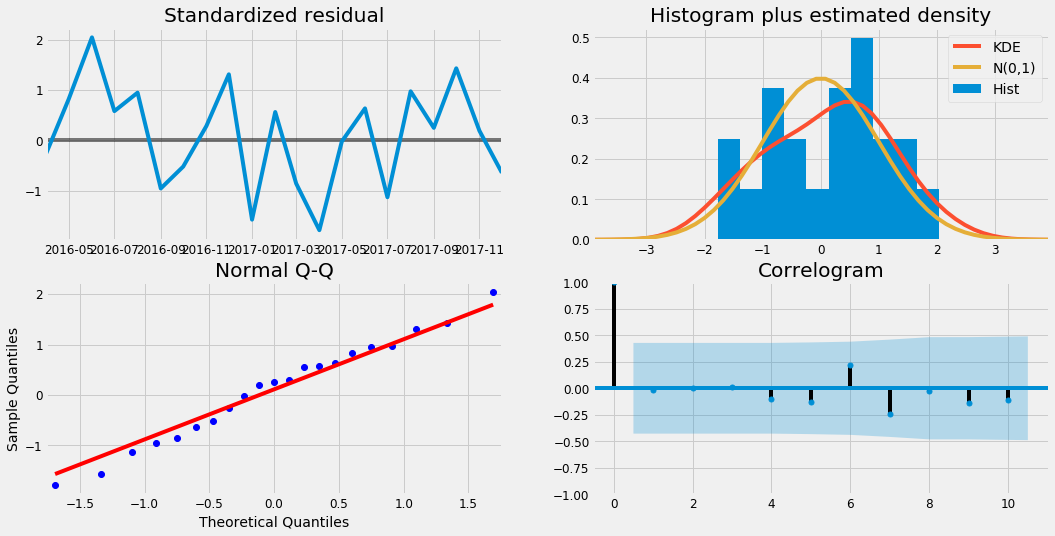

In [62]:
results.plot_diagnostics(figsize=(16,8));

### Validating Forecasts

In [66]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01')
                               , dynamic=False
                              )
pred_ci = pred.conf_int()

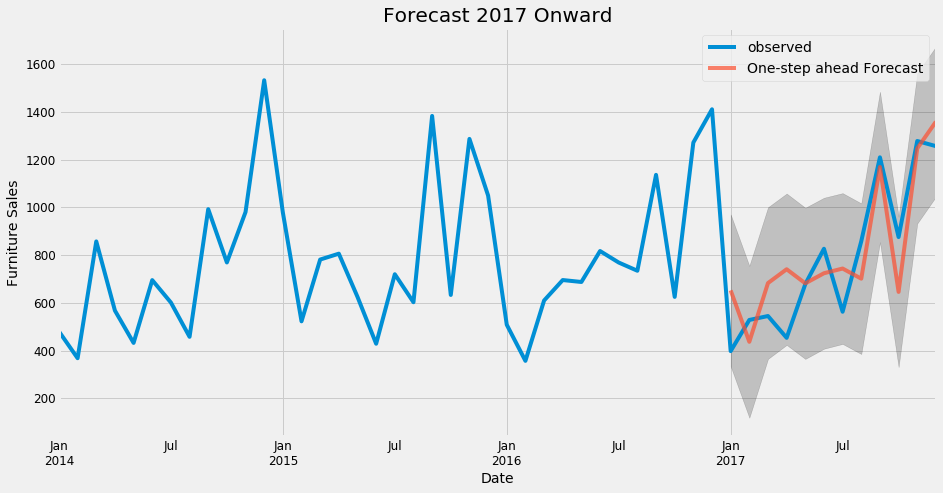

In [71]:
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax = ax
                         , label='One-step ahead Forecast'
                         , alpha = 0.7
                         , figsize=(14,7)
                         )

ax.fill_between(pred_ci.index
                , pred_ci.iloc[:, 0]
                , pred_ci.iloc[:, 1]
                , color = 'k'
                , alpha = 0.2
               )

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
ax.set_title('Forecast 2017 Onward')
plt.legend();

In [74]:
y_forecasted = pred.predicted_mean
y_true = y['2017-01-01':]

mse = ((y_forecasted - y_true) ** 2).mean()
print(f'The MSE of the forecasts is {round(mse, 4)}')

The MSE of the forecasts is 25708.5407


In [75]:
print(f'The RMSE is {round(mse ** 0.5, 4)}')

The RMSE is 160.3388


### Extending the Forecast...

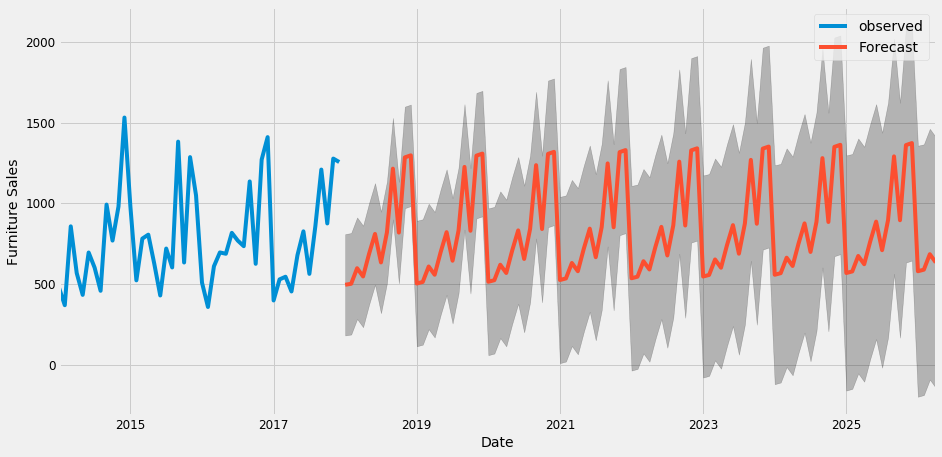

In [77]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed'
            , figsize=(14,7)
           )
pred_uc.predicted_mean.plot(ax=ax
                            , label='Forecast'
                           )
ax.fill_between(pred_ci.index
                , pred_ci.iloc[:, 0]
                , pred_ci.iloc[:, 1]
                , color='k'
                , alpha=0.25
               )
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend();

### Furniture vs. Office Supplies

In [78]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [79]:
furniture.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136


In [82]:
furniture = furniture[['Order Date', 'Sales']]
office = office[['Order Date', 'Sales']]

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

In [83]:
furniture.shape, office.shape

((889, 1), (1148, 1))